In [37]:
%%html
<style>
/*overwrite hard coded write background by vscode for ipywidges */
.cell-output-ipywidget-background {
   background-color: transparent !important;
}

/*set widget foreground text and color of interactive widget to vs dark theme color */
:root {
    --jp-widgets-color: var(--vscode-editor-foreground);
    --jp-widgets-font-size: var(--vscode-editor-font-size);
}
</style>

In [38]:
from amplpy import AMPL

ampl = AMPL()
ampl.read("proj3.mod")
ampl.read_data("proj3.dat")

In [39]:
import pandas as pd


def solve(
    ampl: AMPL,
    epsilon: float = 1e-15,
    beta: float = 0.001,
    aspiration_cost: float = 0,
    aspiration_satisfaction: float = 0,
    lambda_cost: float = 1,
    lambda_satisfaction: float = 50,
):
    targets = ["cost", "satisfaction"]
    ampl.param["EPSILON"] = epsilon
    ampl.param["BETA"] = beta
    ampl.param["ASPIRATION"] = pd.DataFrame([aspiration_cost, aspiration_satisfaction], index=targets)
    ampl.param["LAMBDA"] = pd.DataFrame([lambda_cost, lambda_satisfaction], index=targets)

    ampl.solve(solver="cplex", verbose=False)
    assert ampl.solve_result == "solved"

In [40]:
solve(
    ampl,
    aspiration_cost=200,
    aspiration_satisfaction=3,
    lambda_cost=1,
    lambda_satisfaction=1,
)

print("objective:", ampl.get_current_objective().value())

objective: 0.0008684000000000017


In [41]:
from dataclasses import dataclass

from ipywidgets import HBox, VBox, Layout, HTML as WHTML, Label



@dataclass
class Result:
    flow: pd.DataFrame
    satisfaction: pd.DataFrame
    total_cost: float

    @property
    def total_satisfaction(self):
        return self.satisfaction.values.sum()

    def _ipython_display_(self):
        content = VBox(
            [
                Label(f"total_cost: {self.total_cost}"),
                Label(f"total_satisfaction: {self.total_satisfaction}"),
                HBox(
                    layout=Layout(
                        width="100%", display="inline-flex", flex_flow="row wrap"
                    ),
                    children=[
                        WHTML(self.flow.to_html()),
                        WHTML(self.satisfaction.to_html()),
                    ],
                ),
            ]
        )
        display(content)


def get_result(ampl: AMPL) -> Result:
    flow = ampl.get_data("flow").to_pandas()
    flow = flow.set_index(flow.index.set_names(["source", "dest"])).unstack("source")
    flow.index = sorted(flow.index, key=lambda x: ({"M": 1, "K": 2}[x[0]], x[1]))

    satisfaction = ampl.get_data("satisfaction").to_pandas()

    total_cost = ampl.get_value("total_cost")

    return Result(flow=flow, satisfaction=satisfaction, total_cost=total_cost)

In [42]:
result = get_result(ampl)
result

In [43]:
from functools import wraps

@wraps(solve)
def run(ampl: AMPL, *args, **kwargs) -> Result:
    solve(ampl, *args, **kwargs)
    return get_result(ampl)

In [44]:
result_cost = run(ampl, aspiration_satisfaction=0, aspiration_cost=0)
result_cost

In [45]:
result_satisfaction = run(ampl, aspiration_satisfaction=5, aspiration_cost=1e6)
result_satisfaction

In [46]:
import numpy as np

cost_aspirations = np.linspace(
    result_satisfaction.total_cost, result_cost.total_cost, 50
)

results = [
    run(ampl, aspiration_satisfaction=0, aspiration_cost=cost)
    for cost in cost_aspirations
]

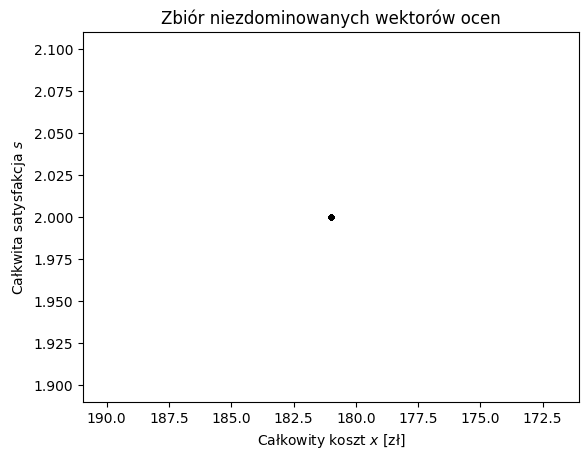

In [47]:
from matplotlib import pyplot as plt

effective_costs = np.array([result.total_cost for result in results])
effective_satisfactions = np.array([result.total_satisfaction for result in results])

plt.plot(effective_costs, effective_satisfactions, "ko-", markersize=3)
plt.subplot().invert_xaxis()
plt.title("Zbiór niezdominowanych wektorów ocen")
plt.xlabel("Całkowity koszt $x$ [zł]")
plt.ylabel("Całkwita satysfakcja $s$")
plt.show()

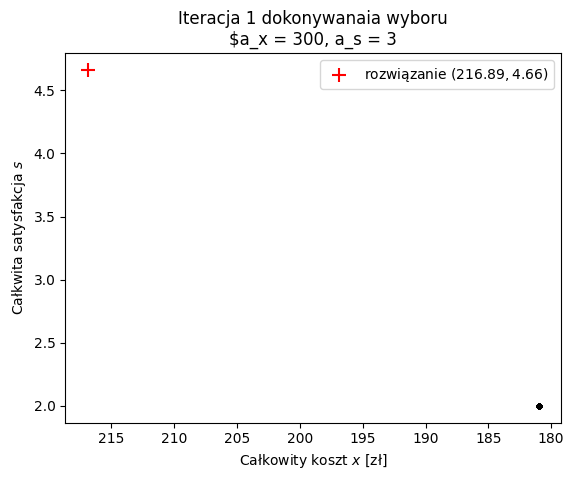

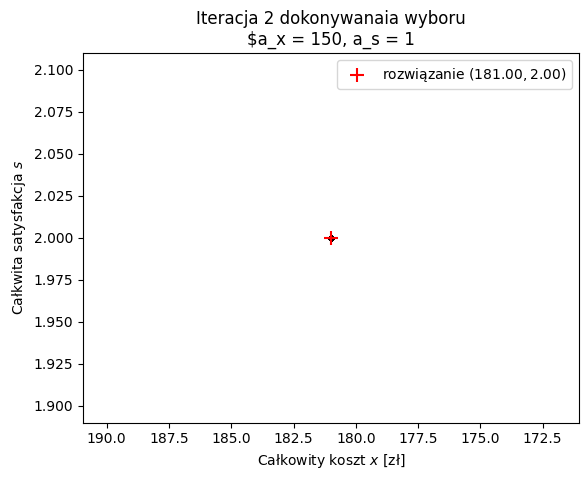

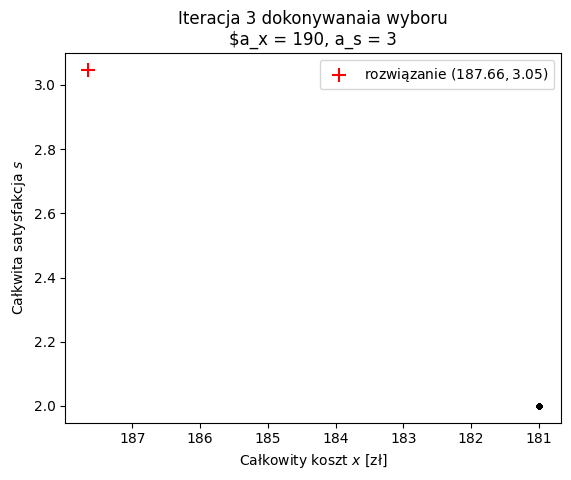

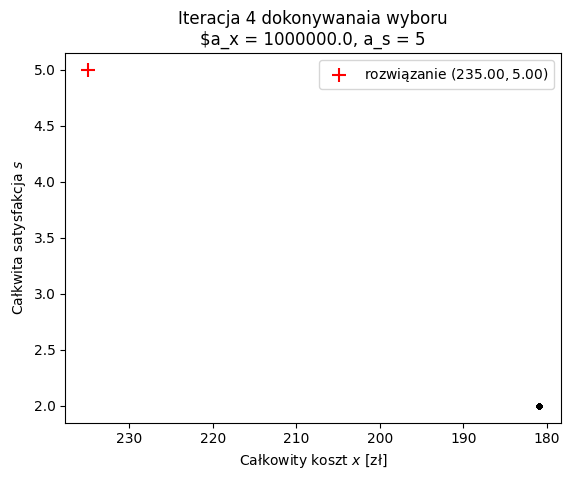

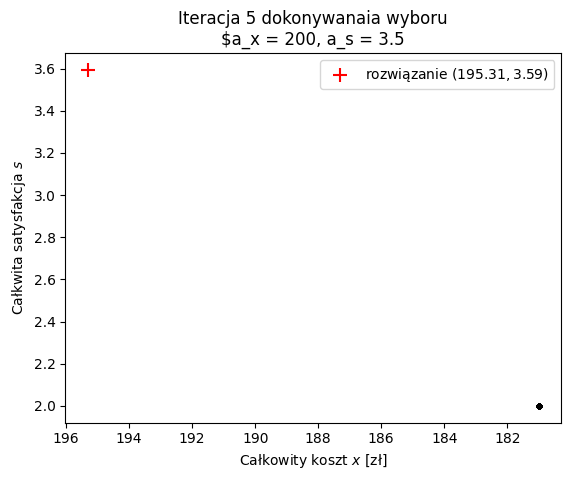

In [48]:
cost_min = effective_costs.min()
cost_max = effective_costs.max()
satisfaction_min = effective_satisfactions.min()
satisfaction_max = effective_satisfactions.max()


@wraps(solve)
def decide_iteration(i: int, *args, aspiration_cost, aspiration_satisfaction, **kwargs):
    result = run(
        *args,
        aspiration_cost=aspiration_cost,
        aspiration_satisfaction=aspiration_satisfaction,
        **kwargs,
    )

    cost_in_range = aspiration_cost >= cost_min and aspiration_cost <= cost_max
    satisfaction_in_range = (
        aspiration_satisfaction >= satisfaction_min
        and aspiration_satisfaction <= satisfaction_max
    )

    plt.plot(effective_costs, effective_satisfactions, "ko-", markersize=3, zorder=1)
    if cost_in_range and satisfaction_in_range:
        plt.scatter(
            aspiration_cost,
            aspiration_satisfaction,
            c="g",
            marker="x",
            s=50,
            zorder=2,
            label="punkt aspiracji",
        )
    plt.scatter(
        result.total_cost,
        result.total_satisfaction,
        c="r",
        marker="+",
        s=100,
        zorder=3,
        label=f"rozwiązanie $({result.total_cost:.2f}, {result.total_satisfaction:.2f})$",
    )

    plt.subplot().invert_xaxis()
    plt.title(
        f"Iteracja {i} dokonywanaia wyboru\n"
        f"$a_x = {aspiration_cost}, a_s = {aspiration_satisfaction}"
    )
    plt.xlabel("Całkowity koszt $x$ [zł]")
    plt.ylabel("Całkwita satysfakcja $s$")
    plt.legend()
    plt.show()


decide_iteration(1, ampl, aspiration_cost=300, aspiration_satisfaction=3)
decide_iteration(2, ampl, aspiration_cost=150, aspiration_satisfaction=1)
decide_iteration(3, ampl, aspiration_cost=190, aspiration_satisfaction=3)
decide_iteration(4, ampl, aspiration_cost=1e6, aspiration_satisfaction=5)
decide_iteration(5, ampl, aspiration_cost=200, aspiration_satisfaction=3.5)